In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import cvlib as cv
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



In [2]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)

{'man': 0, 'woman': 1}


In [16]:
#Preprocess data
img_size=96
data=[]
label=[]

for category in categories:
    folder_path = os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        face, confidence = cv.detect_face(img)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)     
        for idx, f in enumerate(face):   
            (startX, startY) = f[0], f[1]
            (endX, endY) = f[2], f[3]
            face_crop = np.copy(gray[startY:endY,startX:endX])
            
            if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
                continue
                
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            label.append(label_dict[category])

print(f"Number of faces ={len(data)}")

Number of faces =5164


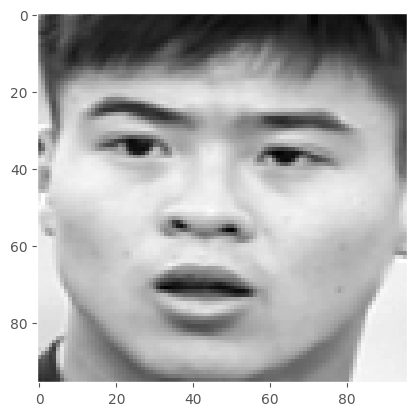

In [17]:
plt.figure()
plt.grid(None)
plt.imshow(data[6],cmap = 'gray')
plt.show()

In [18]:
#Normalization
new_data=np.array(data)/255.0
#One-hot coding
new_label=np_utils.to_categorical(label)
np.save('./training/data',new_data)
np.save('./training/label',new_label)

In [3]:
#Load preprocessed-data
data=np.load('./training/data.npy')
label=np.load('./training/label.npy')
data = data.reshape(data.shape[0],96,96,1)

In [4]:
# Split data into 3 parts: Train,Validation,Test data
train_data,test_data,train_label,test_label=train_test_split(data,label,test_size=0.1)
train_data,val_data,train_label,val_label = train_test_split(train_data,train_label,test_size=0.1)
print(f"Length of Train data: {len(train_data)}")
print(f"Length of Test data: {len(test_data)}")
print(f"Length of Validation data: {len(val_data)}")

Length of Train data: 4182
Length of Test data: 517
Length of Validation data: 465


In [36]:
epochs = 100
sizeOfFilter1=(3,3)
sizeOfFilter2=(3,3)

sizeOfPool=(2,2)
noOfNode=256

model=Sequential()
model.add((Conv2D(32, sizeOfFilter1, input_shape=(96,96,1),activation='relu')))
model.add(BatchNormalization())
model.add((Conv2D(32, sizeOfFilter1,activation='relu')))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=sizeOfPool))
model.add(Dropout(0.05))

model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
model.add(BatchNormalization())
model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=sizeOfPool))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(noOfNode, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(2, activation='softmax'))


In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [38]:
# Image augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# prepare iterator
it_train = datagen.flow(train_data, train_label, batch_size=64)


In [39]:
# Train model
checkpoint = ModelCheckpoint('./training/model-{epoch:03d}.model',monitor='val_accuracy',verbose=1,save_best_only=True,mode='auto')
History = model.fit_generator(it_train,epochs=epochs,validation_data=(val_data,val_label),callbacks=[checkpoint])

C:\Users\Admin\anaconda3\envs\cv2\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
66/66 [==============================] - 5s 61ms/step - loss: 0.7407 - accuracy: 0.7121 - val_loss: 0.7089 - val_accuracy: 0.5742

Epoch 00001: val_accuracy improved from -inf to 0.57419, saving model to ./training\model-001.model
INFO:tensorflow:Assets written to: ./training\model-001.model\assets
Epoch 2/100
66/66 [==============================] - 4s 59ms/step - loss: 0.4724 - accuracy: 0.7817 - val_loss: 0.8590 - val_accuracy: 0.5333

Epoch 00002: val_accuracy did not improve from 0.57419
Epoch 3/100
66/66 [==============================] - 4s 59ms/step - loss: 0.4457 - accuracy: 0.7994 - val_loss: 1.4850 - val_accuracy: 0.5419

Epoch 00003: val_accuracy did not improve from 0.57419
Epoch 4/100
66/66 [==============================] - 4s 60ms/step - loss: 0.3998 - accuracy: 0.8250 - val_loss: 0.9324 - val_accuracy: 0.5462

Epoch 00004: val_accuracy did not improve from 0.57419
Epoch 5/100
66/66 [==============================] - 4s 60ms/step - loss: 0.3584 - accuracy: 0

66/66 [==============================] - 4s 60ms/step - loss: 0.0393 - accuracy: 0.9845 - val_loss: 0.0638 - val_accuracy: 0.9806

Epoch 00077: val_accuracy did not improve from 0.99140
Epoch 78/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0331 - accuracy: 0.9878 - val_loss: 0.0578 - val_accuracy: 0.9806

Epoch 00078: val_accuracy did not improve from 0.99140
Epoch 79/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0545 - accuracy: 0.9802 - val_loss: 0.1085 - val_accuracy: 0.9548

Epoch 00079: val_accuracy did not improve from 0.99140
Epoch 80/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0544 - accuracy: 0.9809 - val_loss: 0.1184 - val_accuracy: 0.9699

Epoch 00080: val_accuracy did not improve from 0.99140
Epoch 81/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0417 - accuracy: 0.9873 - val_loss: 0.1930 - val_accuracy: 0.9419

Epoch 00081: val_accuracy did not improve from 0.99140
Epoch 82/100
66/66

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 64)       

In [5]:
# load model
model = load_model('./training\model-065.model')
# Test with Test data
score = model.evaluate(test_data, test_label, verbose=1)
print(score)

17/17 [==============================] - 8s 17ms/step - loss: 0.0201 - accuracy: 0.9961
[0.02014726772904396, 0.9961315393447876]


In [9]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred,axis = 1)

2


C:\Users\Admin\AppData\Local\Temp\ipykernel_7540\2536699914.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 6, i+1)


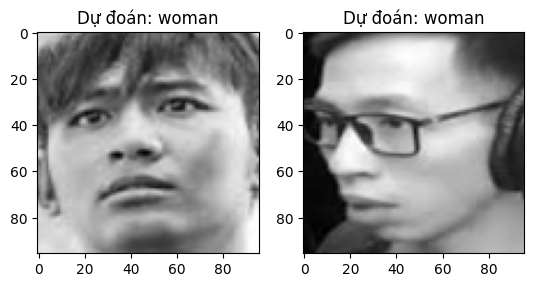

In [11]:
y_test = np.argmax(test_label,axis = 1)
X = np.asarray(y_test != y_pred).reshape(517)
X_wrong = test_data[X]
y_wrong = y_pred[y_test != y_pred]

print(np.sum(y_test != y_pred))
plt.figure(figsize = (20,20))
plt.grid(None)
for i in range(2):
    plt.subplot(1, 6, i+1)
    plt.imshow((X_wrong[i]),cmap = "gray")
    j = y_wrong[i]
    plt.title(f"Dự đoán: {categories[j]}")

In [33]:
# Save model
model.save('gender_detection.model')

INFO:tensorflow:Assets written to: gender_detection.model\assets


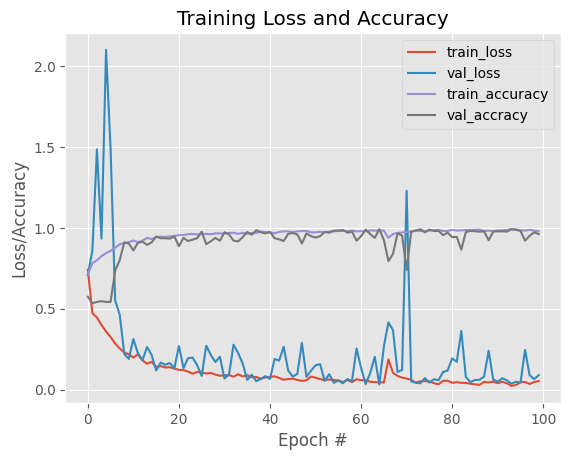

In [44]:
#Plot Training Loss and Accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs

plt.plot(np.arange(0,N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), History.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,N), History.history["val_accuracy"], label="val_accracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right");

In [7]:
import numpy as np
import cv2
import os
import cvlib as cv
                    
# open webcam
capture = cv2.VideoCapture(0)
    
classes = ['man','woman']

# loop through frames
while capture.isOpened():

    # read frame from webcam 
    status, frame = capture.read()
    
    # apply face detection
    face, confidence = cv.detect_face(frame)
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)


    # loop through detected faces
    for idx, f in enumerate(face):
        
        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        # crop the detected face region
        face_crop = np.copy(gray[startY:endY,startX:endX])
        
        

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop/ 255.0
        face_crop = face_crop.reshape((1,96,96,1))
        

        # apply gender detection on face
        conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)


        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
capture.release()
cv2.destroyAllWindows()


In [9]:
# Exit webcam immediately
capture.release()
cv2.destroyAllWindows()
cv2.waitKey(0)

-1

In [9]:
git init

SyntaxError: invalid syntax (2830201818.py, line 1)